In [2]:
# Data manipulation
import pandas as pd
import numpy as np
# Evaluation of the model
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.size'] = 18
%matplotlib inline
MAX_EVALS = 20
import csv
from hyperopt import STATUS_OK
from timeit import default_timer as timer
import json
import shlex
import subprocess
import logging
from pprint import pprint
import re
import os

In [4]:
file_suffix = "IOR-t-128K-b-100M-n-8" + str(MAX_EVALS)
project_dir = "/home/dsinghvi/project/progress/"
def runthebenchmark(hyperparameters):
    os.chdir(project_dir+'active/../')
    storeinfile(hyperparameters)
    out=subprocess.Popen(["python3","ior_read_config_general.py","-n 8","-c-t 128K -b 100M"], shell=False, stdout=subprocess.PIPE)
    logging.basicConfig(level=logging.DEBUG)
    output=out.stdout.read().decode('utf-8')
    print("output"+output)
    if len(output.split(" ")) > 5:
        values = output.split(" ")
        value = float(float(values[2])) + float(float(values[5]))
        value = float(value)
        print(value)
        return float((value/100)**3),output
    return 0,0;

In [5]:
def storeinfile(hyperparameters):
    data={"mpi": {"romio_ds_read": "enable", "romio_ds_write": "disable"}, "lfs": {"setstripe": {"size": "16777216", "count": 4}}}
    data["lfs"]["setstripe"]["size"] = int(hyperparameters["setstripe-size"])
    data["lfs"]["setstripe"]["count"] = int(hyperparameters["setstripe-count"])

    data["mpi"]["romio_ds_read"] = hyperparameters["romio_ds_read"]
    data["mpi"]["romio_ds_write"] = hyperparameters["romio_ds_write"]
    data["mpi"]["romio_cb_read"] = hyperparameters["romio_cb_read"]
    data["mpi"]["romio_cb_write"] = hyperparameters["romio_cb_write"]
    data["mpi"]["cb_buffer_size"] = str(int(hyperparameters["cb_buffer_size"]))
    with open("confex.json","w") as fp:
        json.dump(data,fp)
    print(data)


In [6]:
def objective(hyperparameters):
    global ITERATION
    ITERATION += 1
    start = timer()
    result=0
    while(result == 0):
        print("rerun")
        result,output = runthebenchmark(hyperparameters)
        print(result)
    run_time = timer() - start
    print({'loss': result, 'hyperparameters': hyperparameters, 'iteration': ITERATION, 'iteration_time': run_time, 'status': STATUS_OK})
    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([float(result), hyperparameters, ITERATION, run_time, output])
    return {'loss': float(result), 'hyperparameters': hyperparameters, 'iteration': ITERATION, 'iteration_time': run_time, 'status': STATUS_OK}


In [7]:
from hyperopt import hp
from hyperopt.pyll.stochastic import sample

space = {
    'romio_ds_read' : hp.choice('romio_ds_read',['enable','disable']),
    'romio_ds_write' : hp.choice('romio_ds_write',['enable','disable']),
    'romio_cb_read' : hp.choice('romio_cb_read',['enable','disable']),
    'romio_cb_write' : hp.choice('romio_cb_write',['enable','disable']),
    'cb_buffer_size' : 1048576*hp.quniform('cb_buffer_size',1,512,1),
    'setstripe-size' : 65536*(hp.quniform('setstripe-size',0,512,1)),
    'setstripe-count' : hp.quniform('setstripe-count',0,20,1)
    
}

In [8]:
x = sample(space)
params = x
print(x)

cb_buffer_size_dist = []
for _ in range(1000):
    cb_buffer_size_dist.append(sample(space)['cb_buffer_size'])
    
setstripe_size_dist = []
for _ in range(1000):
    setstripe_size_dist.append(sample(space)['setstripe-size'])
    
setstripe_count_dist = []
for _ in range(1000):
    setstripe_count_dist.append(sample(space)['setstripe-count']) 
    
romio_ds_read_dist = []
for _ in range(20):
    romio_ds_read_dist.append(sample(space)['romio_ds_read'])
    
romio_ds_write_dist = []
for _ in range(20):
    romio_ds_write_dist.append(sample(space)['romio_ds_write'])
    
romio_cb_read_dist = []
for _ in range(20):
    romio_cb_read_dist.append(sample(space)['romio_cb_read']) 
    
romio_cb_write_dist = []
for _ in range(20):
    romio_cb_write_dist.append(sample(space)['romio_cb_write']) 
    

{'cb_buffer_size': 398458880.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 2.0, 'setstripe-size': 31064064.0}


In [9]:
# File to save first results
print(os.getcwd())
out_file = project_dir+'active/result/gbm_trials-'+file_suffix+'.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)
writer.writerow(['loss', 'params', 'iteration', 'train_time', 'output'])
of_connection.close()

/home/dsinghvi/project/progress/active


In [11]:
from hyperopt import tpe

# Create the algorithm
tpe_algorithm = tpe.suggest


from hyperopt import Trials

# Record results
bayes_trials = Trials()

from hyperopt import fmin


ITERATION = 20

best = fmin(fn = objective, space = space, algo = tpe.suggest, trials = bayes_trials, max_evals = MAX_EVALS)

  0%|          | 0/20 [00:00<?, ?it/s, best loss: ?]

INFO:hyperopt.tpe:tpe_transform took 0.009329 seconds
INFO:hyperopt.tpe:TPE using 0 trials


rerun                                               
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '529530880'}, 'lfs': {'setstripe': {'size': 29360128, 'count': 4}}}
outputIOR -t-128K--b-100M-n- 8 922.06 102400 6.93 144.94 102400 44.13 0.053423 10.49 29360128 4 disable disable disable enable 529530880 

14.93                                               
0.0033279701569999993                               
{'loss': 0.0033279701569999993, 'hyperparameters': {'cb_buffer_size': 529530880.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 4.0, 'setstripe-size': 29360128.0}, 'iteration': 21, 'iteration_time': 55.65050221513957, 'status': 'ok'}
  5%|▌         | 1/20 [00:55<17:37, 55.68s/it, best loss: 0.0033279701569999993]

INFO:hyperopt.tpe:tpe_transform took 0.009523 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 0.003328


rerun                                                                           
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '17825792'}, 'lfs': {'setstripe': {'size': 1900544, 'count': 0}}}
outputIOR -t-128K--b-100M-n- 8 774.43 102400 8.25 163.85 102400 39.04 0.032799 8.040000000000001 1900544 0 enable enable enable disable 17825792 

16.25                                                                           
0.004291015625                                                                  
{'loss': 0.004291015625, 'hyperparameters': {'cb_buffer_size': 17825792.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 0.0, 'setstripe-size': 1900544.0}, 'iteration': 22, 'iteration_time': 51.458053613081574, 'status': 'ok'}
 10%|█         | 2/20 [01:47<16:19, 54.42s/it, best loss: 0.0033279701569999993]

INFO:hyperopt.tpe:tpe_transform took 0.009320 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 0.003328


rerun                                                                           
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': '90177536'}, 'lfs': {'setstripe': {'size': 24510464, 'count': 19}}}
outputIOR -t-128K--b-100M-n- 8 203.36 102400 31.46 372.53 102400 17.15 0.035208 33.269999999999996 24510464 19 disable disable enable enable 90177536 

39.46                                                                           
0.061442834536                                                                  
{'loss': 0.061442834536, 'hyperparameters': {'cb_buffer_size': 90177536.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 19.0, 'setstripe-size': 24510464.0}, 'iteration': 23, 'iteration_time': 53.29265660699457, 'status': 'ok'}
 15%|█▌        | 3/20 [02:40<15:19, 54.09s/it, best loss: 0.0033279701569999993]

INFO:hyperopt.tpe:tpe_transform took 0.010988 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 0.003328


rerun                                                                           
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '412090368'}, 'lfs': {'setstripe': {'size': 30474240, 'count': 12}}}
outputIOR -t-128K--b-100M-n- 8 974.27 102400 6.56 474.23 102400 13.48 0.026267 8.04 30474240 12 enable enable disable disable 412090368 

14.559999999999999                                                              
0.0030866268159999988                                                           
{'loss': 0.0030866268159999988, 'hyperparameters': {'cb_buffer_size': 412090368.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 12.0, 'setstripe-size': 30474240.0}, 'iteration': 24, 'iteration_time': 24.152553931809962, 'status': 'ok'}
 20%|██        | 4/20 [03:04<12:01, 45.12s/it, best loss: 0.0030866268159999988]

INFO:hyperopt.tpe:tpe_transform took 0.009519 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 0.003087


rerun                                                                           
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '408944640'}, 'lfs': {'setstripe': {'size': 1114112, 'count': 8}}}
outputIOR -t-128K--b-100M-n- 8 955.73 102400 6.69 394.36 102400 16.20 0.04355 7.17 1114112 8 enable enable enable disable 408944640 

14.690000000000001                                                              
0.003170044709                                                                  
{'loss': 0.003170044709, 'hyperparameters': {'cb_buffer_size': 408944640.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 8.0, 'setstripe-size': 1114112.0}, 'iteration': 25, 'iteration_time': 27.09434239193797, 'status': 'ok'}
 25%|██▌       | 5/20 [03:31<09:55, 39.72s/it, best loss: 0.0030866268159999988]

INFO:hyperopt.tpe:tpe_transform took 0.009317 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 0.003087


rerun                                                                           
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '48234496'}, 'lfs': {'setstripe': {'size': 26411008, 'count': 18}}}
outputIOR -t-128K--b-100M-n- 8 1245.02 102400 5.13 392.71 102400 16.27 0.041994000000000004 3.8600000000000003 26411008 18 enable disable disable disable 48234496 

13.129999999999999                                                              
0.002263571297                                                                  
{'loss': 0.002263571297, 'hyperparameters': {'cb_buffer_size': 48234496.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 18.0, 'setstripe-size': 26411008.0}, 'iteration': 26, 'iteration_time': 25.52549745514989, 'status': 'ok'}
 30%|███       | 6/20 [03:57<08:16, 35.47s/it, best loss: 0.0022635712

INFO:hyperopt.tpe:tpe_transform took 0.009348 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 0.002264


rerun                                                                    
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': '79691776'}, 'lfs': {'setstripe': {'size': 22740992, 'count': 15}}}
outputIOR -t-128K--b-100M-n- 8 821.70 102400 7.78 410.21 102400 15.57 0.035234 5.9399999999999995 22740992 15 disable enable enable enable 79691776 

15.780000000000001                                                       
0.003929352552000002                                                     
{'loss': 0.003929352552000002, 'hyperparameters': {'cb_buffer_size': 79691776.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 15.0, 'setstripe-size': 22740992.0}, 'iteration': 27, 'iteration_time': 27.534352470189333, 'status': 'ok'}
 35%|███▌      | 7/20 [04:24<07:10, 33.10s/it, best loss: 0.002263571297]

INFO:hyperopt.tpe:tpe_transform took 0.005385 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 0.002264


rerun                                                                    
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '505413632'}, 'lfs': {'setstripe': {'size': 28639232, 'count': 15}}}
outputIOR -t-128K--b-100M-n- 8 373.16 102400 17.14 579.51 102400 11.02 0.029995 17.669999999999998 28639232 15 enable enable disable enable 505413632 

25.14                                                                    
0.015888972744                                                           
{'loss': 0.015888972744, 'hyperparameters': {'cb_buffer_size': 505413632.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 15.0, 'setstripe-size': 28639232.0}, 'iteration': 28, 'iteration_time': 32.68351684883237, 'status': 'ok'}
 40%|████      | 8/20 [04:57<06:35, 32.98s/it, best loss: 0.002263571297]

INFO:hyperopt.tpe:tpe_transform took 0.009836 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 0.002264


rerun                                                                    
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': '35651584'}, 'lfs': {'setstripe': {'size': 7012352, 'count': 19}}}
outputIOR -t-128K--b-100M-n- 8 750.83 102400 8.51 506.12 102400 12.62 0.041723 9.469999999999999 7012352 19 disable disable enable enable 35651584 

16.509999999999998                                                       
0.004500297450999997                                                     
{'loss': 0.004500297450999997, 'hyperparameters': {'cb_buffer_size': 35651584.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 19.0, 'setstripe-size': 7012352.0}, 'iteration': 29, 'iteration_time': 25.345288021489978, 'status': 'ok'}
 45%|████▌     | 9/20 [05:22<05:37, 30.70s/it, best loss: 0.002263571297]

INFO:hyperopt.tpe:tpe_transform took 0.111579 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 0.002264


rerun                                                                    
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '63963136'}, 'lfs': {'setstripe': {'size': 8847360, 'count': 1}}}
outputIOR -t-128K--b-100M-n- 8 741.79 102400 8.62 373.76 102400 17.10 0.036919999999999994 7.64 8847360 1 disable enable disable disable 63963136 

16.619999999999997                                                       
0.004590849527999999                                                     
{'loss': 0.004590849527999999, 'hyperparameters': {'cb_buffer_size': 63963136.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 1.0, 'setstripe-size': 8847360.0}, 'iteration': 30, 'iteration_time': 29.853879963047802, 'status': 'ok'}
 50%|█████     | 10/20 [05:52<05:04, 30.48s/it, best loss: 0.002263571297]

INFO:hyperopt.tpe:tpe_transform took 0.009667 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss 0.002264


rerun                                                                     
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '198180864'}, 'lfs': {'setstripe': {'size': 21889024, 'count': 4}}}
outputIOR -t-128K--b-100M-n- 8 373.12 102400 17.14 429.55 102400 14.87 0.043826000000000004 17.3 21889024 4 disable disable disable enable 198180864 

25.14                                                                     
0.015888972744                                                            
{'loss': 0.015888972744, 'hyperparameters': {'cb_buffer_size': 198180864.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 4.0, 'setstripe-size': 21889024.0}, 'iteration': 31, 'iteration_time': 36.443355487659574, 'status': 'ok'}
 55%|█████▌    | 11/20 [06:29<04:50, 32.28s/it, best loss: 0.002263571297]

INFO:hyperopt.tpe:tpe_transform took 0.009766 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss 0.002264


rerun                                                                     
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '123731968'}, 'lfs': {'setstripe': {'size': 19660800, 'count': 9}}}
outputIOR -t-128K--b-100M-n- 8 336.72 102400 19.00 393.74 102400 16.22 0.037753999999999996 18.67 19660800 9 enable disable enable disable 123731968 

27.0                                                                      
0.019683000000000003                                                      
{'loss': 0.019683000000000003, 'hyperparameters': {'cb_buffer_size': 123731968.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 9.0, 'setstripe-size': 19660800.0}, 'iteration': 32, 'iteration_time': 40.15473453048617, 'status': 'ok'}
 60%|██████    | 12/20 [07:09<04:37, 34.65s/it, best loss: 0.002263571297]

INFO:hyperopt.tpe:tpe_transform took 0.009476 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss 0.002264


rerun                                                                     
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '45088768'}, 'lfs': {'setstripe': {'size': 17235968, 'count': 18}}}
outputIOR -t-128K--b-100M-n- 8 910.59 102400 7.02 553.26 102400 11.55 0.031549 5.625789999999999 17235968 18 enable enable disable enable 45088768 

15.02                                                                     
0.003388518008                                                            
{'loss': 0.003388518008, 'hyperparameters': {'cb_buffer_size': 45088768.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 18.0, 'setstripe-size': 17235968.0}, 'iteration': 33, 'iteration_time': 22.730121965520084, 'status': 'ok'}
 65%|██████▌   | 13/20 [07:32<03:37, 31.08s/it, best loss: 0.002263571297]

INFO:hyperopt.tpe:tpe_transform took 0.009963 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss 0.002264


rerun                                                                     
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '118489088'}, 'lfs': {'setstripe': {'size': 13303808, 'count': 12}}}
outputIOR -t-128K--b-100M-n- 8 972.15 102400 6.57 548.61 102400 11.64 0.041856000000000004 5.6 13303808 12 disable enable disable enable 118489088 

14.57                                                                     
0.003092990993                                                            
{'loss': 0.003092990993, 'hyperparameters': {'cb_buffer_size': 118489088.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 12.0, 'setstripe-size': 13303808.0}, 'iteration': 34, 'iteration_time': 22.43193285074085, 'status': 'ok'}
 70%|███████   | 14/20 [07:54<02:50, 28.50s/it, best loss: 0.002263571297]

INFO:hyperopt.tpe:tpe_transform took 0.009748 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss 0.002264


rerun                                                                     
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '200278016'}, 'lfs': {'setstripe': {'size': 27918336, 'count': 6}}}
outputIOR -t-128K--b-100M-n- 8 1206.70 102400 5.30 564.56 102400 11.20 0.14572300000000002 3.9 27918336 6 enable disable disable disable 200278016 

13.3                                                                      
0.0023526370000000003                                                     
{'loss': 0.0023526370000000003, 'hyperparameters': {'cb_buffer_size': 200278016.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 6.0, 'setstripe-size': 27918336.0}, 'iteration': 35, 'iteration_time': 20.780481123365462, 'status': 'ok'}
 75%|███████▌  | 15/20 [08:15<02:10, 26.19s/it, best loss: 0.002263571297]

INFO:hyperopt.tpe:tpe_transform took 0.009851 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss 0.002264


rerun                                                                     
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': '161480704'}, 'lfs': {'setstripe': {'size': 13500416, 'count': 17}}}
outputIOR -t-128K--b-100M-n- 8 1180.53 102400 5.41 424.70 102400 15.04 0.042237 8.57 13500416 17 enable disable enable enable 161480704 

13.41                                                                     
0.002411494821                                                            
{'loss': 0.002411494821, 'hyperparameters': {'cb_buffer_size': 161480704.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 17.0, 'setstripe-size': 13500416.0}, 'iteration': 36, 'iteration_time': 24.622451635077596, 'status': 'ok'}
 80%|████████  | 16/20 [08:40<01:42, 25.73s/it, best loss: 0.002263571297]

INFO:hyperopt.tpe:tpe_transform took 0.009522 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss 0.002264


rerun                                                                     
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '51380224'}, 'lfs': {'setstripe': {'size': 14090240, 'count': 7}}}
outputIOR -t-128K--b-100M-n- 8 338.10 102400 18.92 392.35 102400 15.93 0.38922999999999996 18.36 14090240 7 disable enable disable enable 51380224 

26.92                                                                     
0.019508557888                                                            
{'loss': 0.019508557888, 'hyperparameters': {'cb_buffer_size': 51380224.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 7.0, 'setstripe-size': 14090240.0}, 'iteration': 37, 'iteration_time': 39.62414779700339, 'status': 'ok'}
 85%|████████▌ | 17/20 [09:19<01:29, 29.91s/it, best loss: 0.002263571297]

INFO:hyperopt.tpe:tpe_transform took 0.004951 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss 0.002264


rerun                                                                     
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '389021696'}, 'lfs': {'setstripe': {'size': 30932992, 'count': 6}}}
outputIOR -t-128K--b-100M-n- 8 1230.97 102400 5.19 552.25 102400 11.56 0.036012 4.859999999999999 30932992 6 disable enable enable disable 389021696 

13.190000000000001                                                        
0.002294744759000001                                                      
{'loss': 0.002294744759000001, 'hyperparameters': {'cb_buffer_size': 389021696.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 6.0, 'setstripe-size': 30932992.0}, 'iteration': 38, 'iteration_time': 20.958025136962533, 'status': 'ok'}
 90%|█████████ | 18/20 [09:40<00:54, 27.23s/it, best loss: 0.002263571297]

INFO:hyperopt.tpe:tpe_transform took 0.010744 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss 0.002264


rerun                                                                     
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '369098752'}, 'lfs': {'setstripe': {'size': 7798784, 'count': 11}}}
outputIOR -t-128K--b-100M-n- 8 372.22 102400 17.18 447.30 102400 14.29 0.041031 17.19 7798784 11 disable disable enable disable 369098752 

25.18                                                                     
0.015964935832000003                                                      
{'loss': 0.015964935832000003, 'hyperparameters': {'cb_buffer_size': 369098752.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 11.0, 'setstripe-size': 7798784.0}, 'iteration': 39, 'iteration_time': 35.769128360785544, 'status': 'ok'}
 95%|█████████▌| 19/20 [10:16<00:29, 29.80s/it, best loss: 0.002263571297]

INFO:hyperopt.tpe:tpe_transform took 0.009896 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss 0.002264


rerun                                                                     
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '101711872'}, 'lfs': {'setstripe': {'size': 20185088, 'count': 6}}}
outputIOR -t-128K--b-100M-n- 8 1184.65 102400 5.39 574.32 102400 11.11 0.047297000000000006 4.190563 20185088 6 disable enable disable enable 101711872 

13.39                                                                     
0.002400721219000001                                                      
{'loss': 0.002400721219000001, 'hyperparameters': {'cb_buffer_size': 101711872.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 6.0, 'setstripe-size': 20185088.0}, 'iteration': 40, 'iteration_time': 21.182869982905686, 'status': 'ok'}
100%|██████████| 20/20 [10:37<00:00, 27.22s/it, best loss: 0.002263571297]


In [12]:
print(best)
d=  best
#print(bayes_trials.results)
bayes_trials_results = sorted(bayes_trials.results, key = lambda x: x['loss'])
#bayes_trials_results[:1]

{'cb_buffer_size': 46.0, 'romio_cb_read': 1, 'romio_cb_write': 1, 'romio_ds_read': 0, 'romio_ds_write': 1, 'setstripe-count': 18.0, 'setstripe-size': 403.0}


In [13]:
results = pd.read_csv(out_file)

# Sort with best scores on top and reset index for slicing
results.sort_values('train_time', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)
results.head()


,loss,params,iteration,train_time,output
0,0.002471,"{'cb_buffer_size': 53477376.0, 'romio_cb_read'...",31,20.758029,IOR -t-128K--b-100M-n- 8 1158.38 102400 5.52 5...
1,0.002353,"{'cb_buffer_size': 200278016.0, 'romio_cb_read...",35,20.780481,IOR -t-128K--b-100M-n- 8 1206.70 102400 5.30 5...
2,0.002295,"{'cb_buffer_size': 389021696.0, 'romio_cb_read...",38,20.958025,IOR -t-128K--b-100M-n- 8 1230.97 102400 5.19 5...
3,0.002401,"{'cb_buffer_size': 101711872.0, 'romio_cb_read...",40,21.182870,IOR -t-128K--b-100M-n- 8 1184.65 102400 5.39 5...
4,0.003093,"{'cb_buffer_size': 118489088.0, 'romio_cb_read...",34,22.431933,IOR -t-128K--b-100M-n- 8 972.15 102400 6.57 54...


In [14]:
import ast

# Convert from a string to a dictionary
ast.literal_eval(results.loc[0, 'params'])
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()
print(best_bayes_params)
log = open('iorbest.txt','a')
print(results.loc[0,'output'])
print(results.loc[0,'output'],file=log)
log.close()

{'cb_buffer_size': 53477376.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 18.0, 'setstripe-size': 15138816.0}
IOR -t-128K--b-100M-n- 8 1158.38 102400 5.52 580.68 102400 11.00 0.032783 3.181898 15138816 18 disable disable enable disable 53477376 



In [15]:
bayes_params = pd.DataFrame(columns = list(ast.literal_eval(results.loc[0, 'params']).keys()),
                            index = list(range(len(results))))

# Add the results with each parameter a different column
for i, params in enumerate(results['params']):
    bayes_params.loc[i, :] = list(ast.literal_eval(params).values())
bayes_params['train_time'] = results['train_time']    
bayes_params['loss'] = results['loss']
bayes_params['iteration'] = results['iteration']
bayes_params['output']=results['output']

bayes_params.head()

,cb_buffer_size,romio_cb_read,romio_cb_write,romio_ds_read,romio_ds_write,setstripe-count,setstripe-size,train_time,loss,iteration,output
0,5.34774e+07,enable,disable,disable,disable,18,1.51388e+07,20.758029,0.002471,31,IOR -t-128K--b-100M-n- 8 1158.38 102400 5.52 5...
1,2.00278e+08,disable,disable,enable,disable,6,2.79183e+07,20.780481,0.002353,35,IOR -t-128K--b-100M-n- 8 1206.70 102400 5.30 5...
2,3.89022e+08,enable,disable,disable,enable,6,3.0933e+07,20.958025,0.002295,38,IOR -t-128K--b-100M-n- 8 1230.97 102400 5.19 5...
3,1.01712e+08,disable,enable,disable,enable,6,2.01851e+07,21.182870,0.002401,40,IOR -t-128K--b-100M-n- 8 1184.65 102400 5.39 5...
4,1.18489e+08,disable,enable,disable,enable,12,1.33038e+07,22.431933,0.003093,34,IOR -t-128K--b-100M-n- 8 972.15 102400 6.57 54...


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=18.0 to DejaVu Sans ('/home/dsinghvi/project/progress/env/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=21.599999999999998 to DejaVu Sans ('/home/dsinghvi/project/progress/env/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


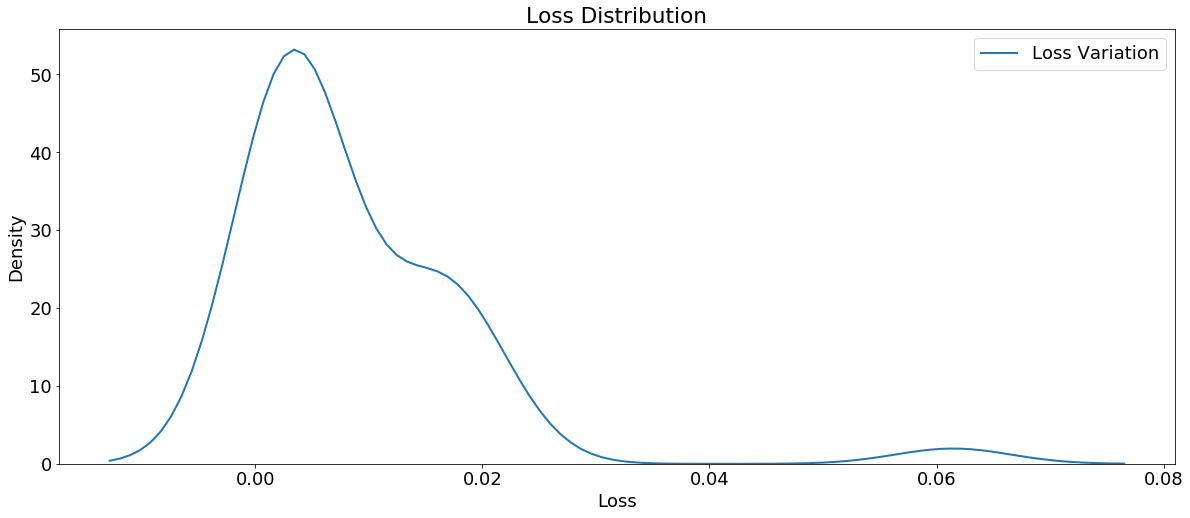

In [16]:
os.chdir('./iorplots')
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

# Density plots of the learning rate distributions 
sns.kdeplot(bayes_params['loss'], label = 'Loss Variation', linewidth = 2)
plt.legend()
plt.xlabel('Loss'); plt.ylabel('Density'); plt.title('Loss Distribution');
plt.savefig(file_suffix+'_loss.png')

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


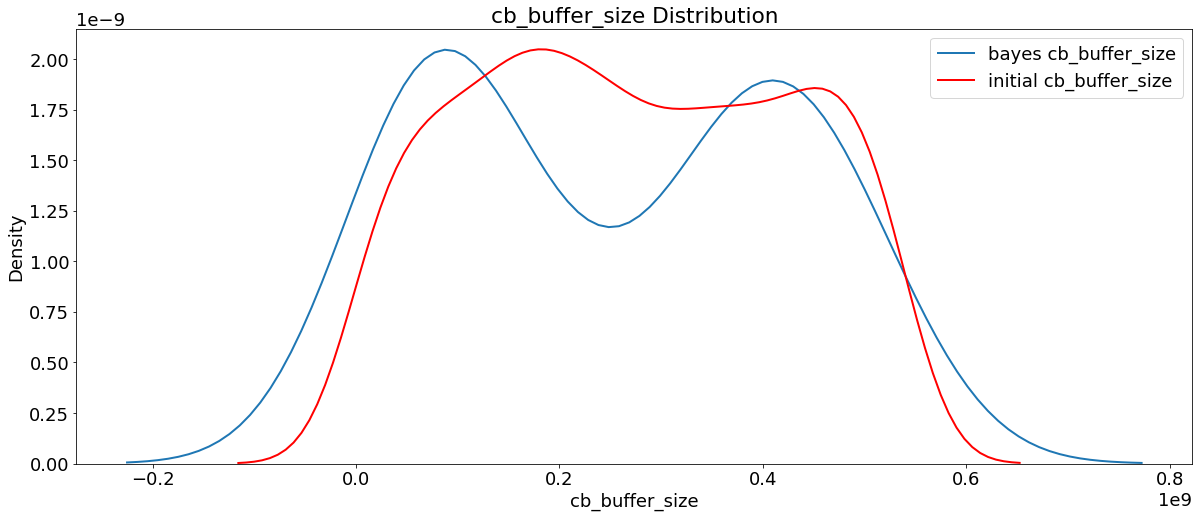

In [17]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18


sns.kdeplot(bayes_params['cb_buffer_size'], label = 'bayes cb_buffer_size', linewidth = 2)
sns.kdeplot(cb_buffer_size_dist,color="red",linewidth=2, label = 'initial cb_buffer_size')

plt.legend()
plt.xlabel('cb_buffer_size'); plt.ylabel('Density'); plt.title('cb_buffer_size Distribution');
plt.savefig(file_suffix+'_cb_buffer_size.png')

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


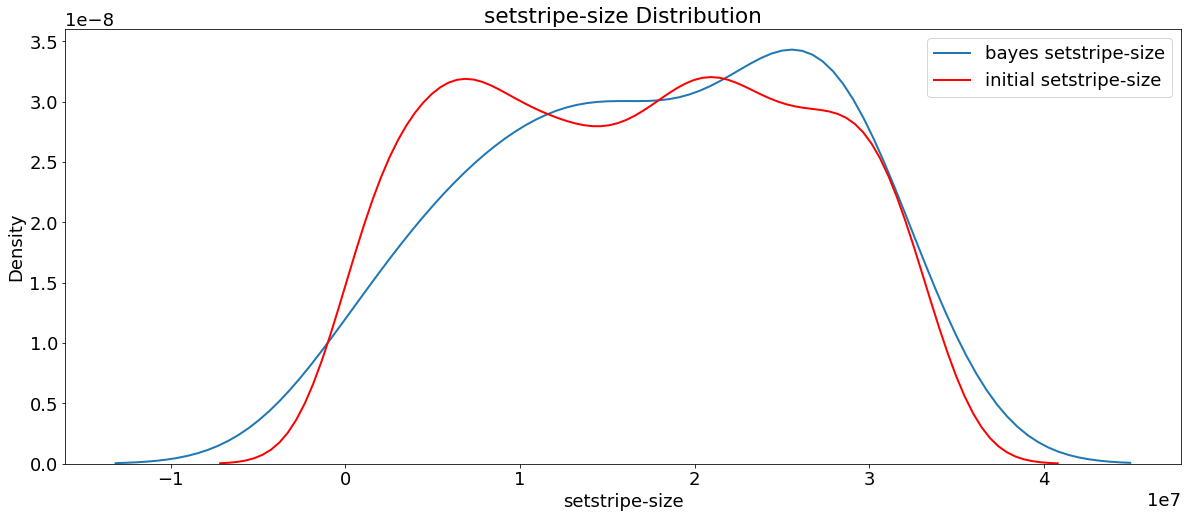

In [18]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

sns.kdeplot(bayes_params['setstripe-size'], label = 'bayes setstripe-size', linewidth = 2)
sns.kdeplot(setstripe_size_dist,color="red",linewidth=2, label = 'initial setstripe-size')

plt.legend()
plt.xlabel('setstripe-size'); plt.ylabel('Density'); plt.title('setstripe-size Distribution');
plt.savefig(file_suffix+'_setstripe-size.png')

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


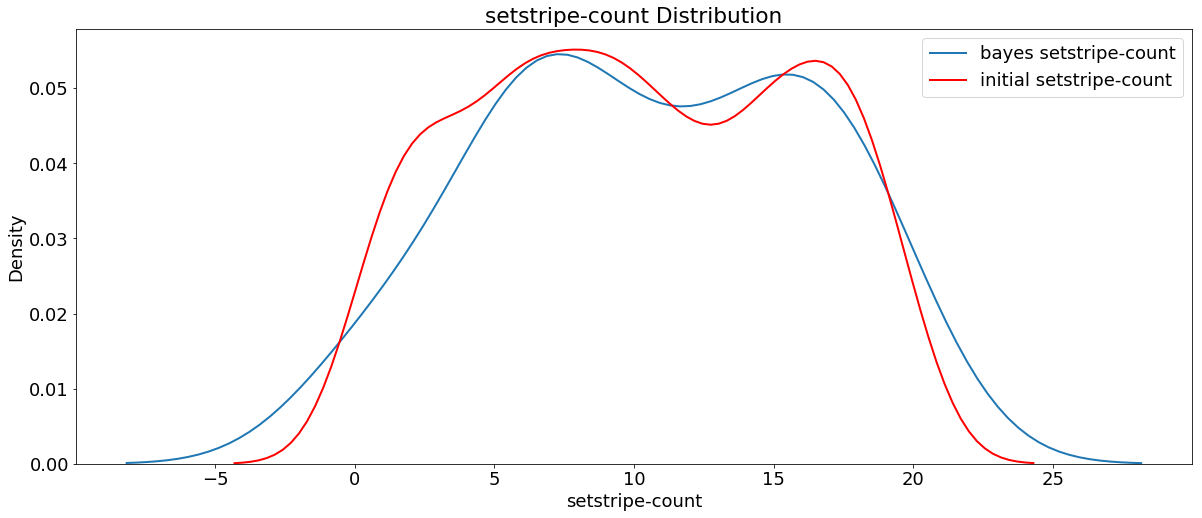

In [19]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

sns.kdeplot(bayes_params['setstripe-count'], label = 'bayes setstripe-count', linewidth = 2)
sns.kdeplot(setstripe_count_dist,color="red",linewidth=2, label = 'initial setstripe-count')

plt.legend()
plt.xlabel('setstripe-count'); plt.ylabel('Density'); plt.title('setstripe-count Distribution');
plt.savefig(file_suffix+'_setstripe-count.png')

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


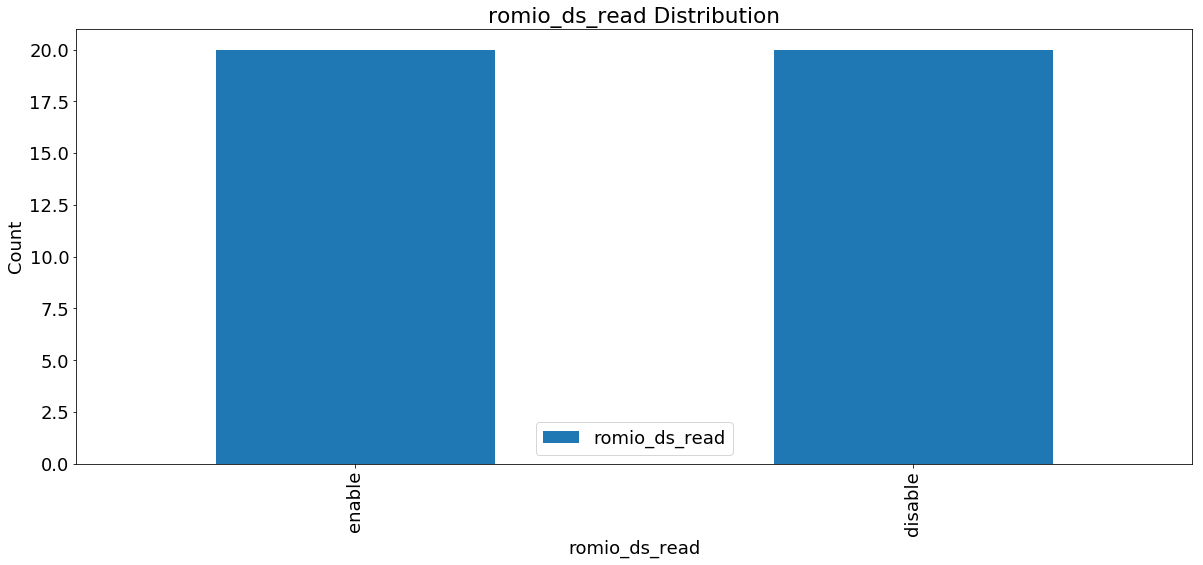

In [20]:
plt.figure(figsize = (20, 8))
from scipy.stats import itemfreq
plt.rcParams['font.size'] = 18
bayes_params['romio_ds_read'].value_counts().plot.bar()#plt.hist(romio_ds_read_dist,color="red",linewidth=2, label = 'initial romio_ds_read')

plt.legend()
plt.xlabel('romio_ds_read'); plt.ylabel('Count'); plt.title('romio_ds_read Distribution');
plt.savefig(file_suffix+'_romio_ds_read.png')

In [ ]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

#plt.hist(bayes_params['romio_ds_write'], label = 'bayes romio_ds_write', linewidth = 2)
#plt.hist(romio_ds_write_dist,color="red",linewidth=2, label = 'initial romio_ds_write')
bayes_params['romio_ds_write'].value_counts().plot.bar()
plt.legend()
plt.xlabel('romio_ds_write'); plt.ylabel('Count'); plt.title('romio_ds_write Distribution');
plt.savefig(file_suffix+'_romio_ds_write.png')

In [ ]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

bayes_params['romio_cb_write'].value_counts().plot.bar()#plt.hist(romio_ds_write_dist,color="red",linewidth=2, label = 'initial romio_cb_write')

plt.legend()
plt.xlabel('romio_cb_write'); plt.ylabel('Count'); plt.title('romio_cb_write Distribution');
plt.savefig(file_suffix+'_romio_cb_write.png')

In [ ]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

bayes_params['romio_cb_read'].value_counts().plot.bar()#plt.hist(romio_cb_read_dist,color="red",linewidth=2, label = 'initial romio_cb_read')

plt.legend()
plt.xlabel('romio_cb_read'); plt.ylabel('Count'); plt.title('romio_cb_read Distribution');
plt.savefig(file_suffix+'_romio_cb_read.png')

In [ ]:
os.chdir('../')